In [1]:
## Install relevant packages
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import tweepy
import os
from textblob import TextBlob
from afinn import Afinn
import re, string
import matplotlib.pyplot as plt

####################################
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

####################################
from wordcloud import WordCloud, STOPWORDS 

####################################
from collections import defaultdict
from gensim import corpora
import pprint

C:\Users\Ritwik\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ritwik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
### Twitter Credentials to extract tweets from Developer Account
os.chdir('C:/Users/Ritwik/OneDrive/BZAN557')  ## Set Working Directory accordingly 

from my_twitter_credentials import get_keys
my_keys = get_keys()
consumer_key = my_keys['consumer_key']
consumer_secret = my_keys['consumer_secret']
access_token = my_keys['access_token']
access_secret = my_keys['access_secret']

# establish connection
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

## API
# set wait_on_rate_limit =True; as twitter may block you from querying if it finds you exceeding some limits
api = tweepy.API(auth, wait_on_rate_limit = True) 

## USA ##

In [ ]:
## Code Chunk to extract tweets 
search_words = ['coronavirus']
## Format for geocode="lattitude,longitude,radius"
## Radius should be in miles or km
tweets = tweepy.Cursor(api.search, search_words,
                       geocode="37.090240,-95.712891,1000km",
                       lang="en").items(5000)
timestamp_str = []
tweet_username = []
tweet_text = []
tweet_location = []
for tweet in tweets:
    timestamp_str.append(tweet.created_at)
    tweet_username.append(tweet.user.screen_name)
    tweet_text.append(tweet.text)
## tweet.user.location will give you the general location of the user and not the particular location 
##for the tweet itself, as it turns out, most of the users do not share the exact location of the tweet
    tweet_location.append(tweet.user.location)

In [ ]:
## Convert the complied list to a Pandas Dataframe
compiled_list = {'Timestamp':timestamp_str,'User':tweet_username,'Tweet':tweet_text,'Location':tweet_location}
df = pd.DataFrame(compiled_list)

In [ ]:
## Save the Dataframe on Disk as a CSV file to avoid Loading it each time
df.to_csv('C:/Users/Ritwik/OneDrive/BZAN557/Project/USA_tweets.csv')

In [3]:
## Load the dataset from Disk
os.chdir('C:/Users/Ritwik/OneDrive/BZAN557/Project')  ## Set Working Directory accordingly 
df_usa = pd.read_csv("USA_tweets.csv") 
del df_usa['Unnamed: 0']

In [4]:
## Convert tweet to a list
tweet = df_usa['Tweet'].values.tolist()

In [5]:
## Remove Noise around the tweets
def clean(sentence):
    sentence = sentence.strip()
    pattern = r'[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
    filtered_sentence = re.sub(pattern, r' ', sentence)
    return filtered_sentence

In [6]:
tweet_clean_usa = []
for ii in tweet:
    tweet_clean_usa.append(clean(ii))

In [7]:
df_usa['Tweet'] = tweet_clean_usa

In [8]:
## Create a Stoplist for words to exclude
stoplist = ['https','co', 'led', 'in', 'is', 'the', 'of', 'the', 'by', 'for', 'its', 'at','when', 'with',
            'have', 'there','are', 'you','our','how','from', 'all','k','to','will','be','who','an',
            '4eyxnzerwfrt', 'drbishnuhnepal', 'rgvzoomin','', 't', 'a', 'and', 's', 'on', 'was', 'but', '3',
           'been', 'so', 'they', 'can', 'your', 'so', 'up', 'if','it', 'has', 'here', 'us','this', 'u', 'he', 'my',
           'says','l', '1','we','do','i','get','more','9','11','157','than','put','re','as','hi','am','because','no',
           'need','me','according','his','that','000','5','who','into','co','t','ql9kqqjsbc','which','would', 'gs7bjv7p86rt',
           '1m','75']

In [9]:
## Make a wordcloud for USA Tweets
wordcloud_usa = ''.join(tweet_clean_usa)

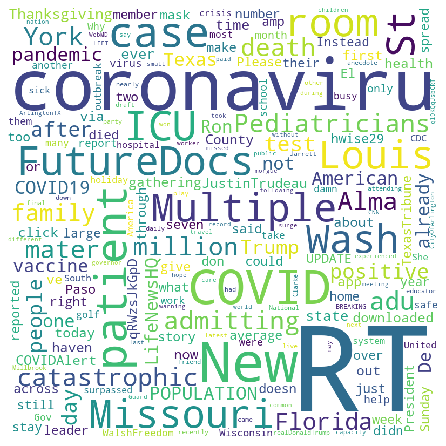

In [10]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stoplist, 
                min_font_size = 10, collocations=False).generate(wordcloud_usa) 

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [11]:
## Tokenize
usa_tokens = wordcloud_usa.lower().strip().split()

In [12]:
## Word Count and Analyses for Tweets
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in usa_tokens]

# Count word frequencies
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear even once
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
## pprint.pprint(processed_corpus)

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(8866 unique tokens: ['rt', 'colmorrisdavis', 'national', 'debt', '27']...)


In [13]:
df_word_usa = pd.DataFrame.from_dict(frequency, orient="index")

In [14]:
df_word_usa.index.name = 'word'
df_word_usa.reset_index(inplace=True)
df_word_usa.columns = ['word', 'frequency']
df_word_usa.sort_values(by=['frequency'], ascending=False)

,word,frequency
0,rt,1818
28,coronavirus,1768
68,new,914
14,covid,712
15,19,692
...,...,...
4621,kellyagallaghe2,1
4620,mountaingirl316,1
4619,luksgibbogibson,1
4618,istired,1


In [15]:
## Filter Words with Frequence Over 100
df_word_usa_100 = df_word_usa[df_word_usa['frequency'] > 100]  
df_word_usa_100 = df_word_usa_100.sort_values(by=['frequency'], ascending=False)

Text(0, 0.5, 'Most Frequent Words')

<Figure size 576x576 with 0 Axes>

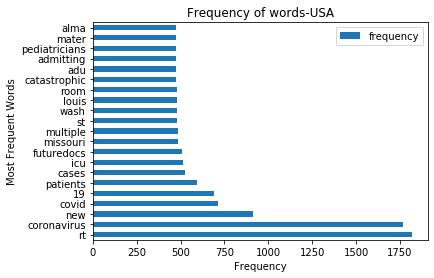

In [16]:
## Make a Bar Plot
df_word_usa_most_freq = df_word_usa_100[0:21]
df_word_usa_most_freq = df_word_usa_most_freq.set_index('word')

# Plot the figure.
plt.figure(figsize=(8, 8))
fig = df_word_usa_most_freq.plot(kind='barh')
fig.set_title('Frequency of words-USA')
fig.set_xlabel('Frequency')
fig.set_ylabel('Most Frequent Words')

In [17]:
from textblob import TextBlob
## Include a column with Polarity Score for Tweets
polarity_score_usa = []
for ii in tweet_clean_usa:
    polarity_score_usa.append(TextBlob(ii).sentiment.polarity)
    
## Add the Polarity Score in the Dataframe
df_usa['Polarity_Score'] = polarity_score_usa

In [18]:
from afinn import Afinn
## Include a column with AFN Score for Tweets
afn = Afinn(emoticons=True) 
afn_score_usa = []
for ii in tweet_clean_usa:
    afn_score_usa.append(afn.score(ii))
    
## Add the Polarity Score in the Dataframe
df_usa['AFN_Score'] = afn_score_usa

In [19]:
##Check
print(len(polarity_score_usa))
print(len(afn_score_usa))

5000
5000


Text(0.5, 1.0, 'Distrbution of Polarity Score (USA)')

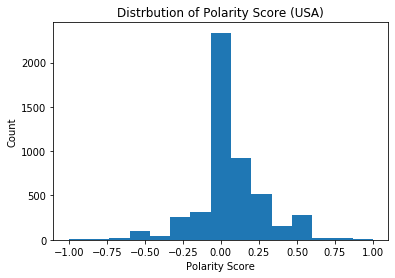

In [20]:
## Distribution of Polarity Score for USA
%matplotlib inline
plt.hist(polarity_score_usa, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('Polarity Score')
plt.title('Distrbution of Polarity Score (USA)')

Text(0.5, 1.0, 'Distrbution of AFN Score (USA)')

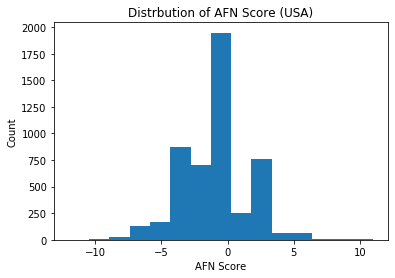

In [21]:
## Distribution of AFN Score for USA
%matplotlib inline
plt.hist(afn_score_usa, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('AFN Score')
plt.title('Distrbution of AFN Score (USA)')

In [22]:
## Polarity Classification based on the Polarity Scores
df_usa['Polarity_Classification'] = np.where(df_usa['Polarity_Score'] == 0 , 'Neutral', 
                                         np.where(df_usa['Polarity_Score'] >0  , 'Positive', 'Negative')) 

In [23]:
## AFN Classification based on the Polarity Scores
df_usa['AFN_Classification'] = np.where(df_usa['AFN_Score'] == 0 , 'Neutral', 
                                         np.where(df_usa['AFN_Score'] >0  , 'Positive', 'Negative')) 

In [24]:
## Check
df_usa.head()

,Timestamp,User,Tweet,Location,Polarity_Score,AFN_Score,Polarity_Classification,AFN_Classification
0,2020-11-23 01:54:57,adrienne_pope,RT ColMorrisDavis The national debt is 27 2...,NaN,0.0,-5.0,Neutral,Negative
1,2020-11-23 01:54:55,eagle_ascending,RT eagle ascending Ben Carson says he s out...,United States,0.0,2.0,Neutral,Positive
2,2020-11-23 01:54:54,starfirst,RT duty2warn Biden has a coronavirus team T...,NaN,0.0,0.0,Neutral,Neutral
3,2020-11-23 01:54:42,The3Buckleys,RT FutureDocs This is catastrophic My Alma ...,"Hogwarts, Ravenclaw Tower",0.0,-4.0,Neutral,Negative
4,2020-11-23 01:54:40,znowflakey,RT KABBFOX29 Inequality baked into virus t...,"Texas, USA",0.0,0.0,Neutral,Neutral


In [25]:
## Count for Polarity Classification
df_usa['Polarity_Classification'].value_counts()

Positive    2163
Neutral     1935
Negative     902
Name: Polarity_Classification, dtype: int64

In [26]:
## Count for AFN Classification
df_usa['AFN_Classification'].value_counts()

Negative    2323
Neutral     1520
Positive    1157
Name: AFN_Classification, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

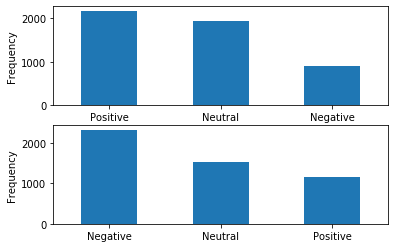

In [27]:
## Plot for Both the Classifications
## The first Plot is for Polarity Classification
plt.subplot(2,1,1)
df_usa['Polarity_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('Polarity Classification')
plt.xticks(rotation=0)
## The Second Plot is for AFN Classification
plt.subplot(2,1,2)
df_usa['AFN_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

In [28]:
# Sentiment Intensity Analyzer for USA
dataframe = df_usa[['Timestamp','User','Tweet']].copy()
dataframe["Comp"] = ''
dataframe["Negative"] = ''
dataframe["Neutral"] = ''
dataframe["Positive"] = ''

sentiment_i_a = SentimentIntensityAnalyzer()
for index, row in df_usa.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', df_usa.loc[index, 'Tweet'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        dataframe.at[index, 'Comp'] = sentence_sentiment['compound']
        dataframe.at[index, 'Negative'] = sentence_sentiment['neg']
        dataframe.at[index, 'Neutral'] = sentence_sentiment['neu']
        dataframe.at[index, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (df_usa.loc[index, 'Tweets'])
        print (index)

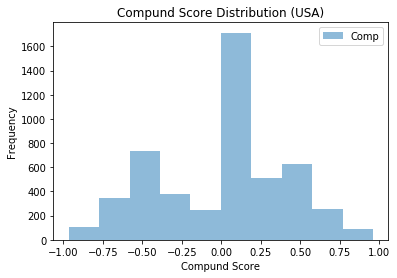

In [29]:
w = dataframe['Comp']
from matplotlib import pyplot
pyplot.hist(w, alpha=0.5, label='Comp')
pyplot.title('Compund Score Distribution (USA)')
pyplot.xlabel('Compund Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

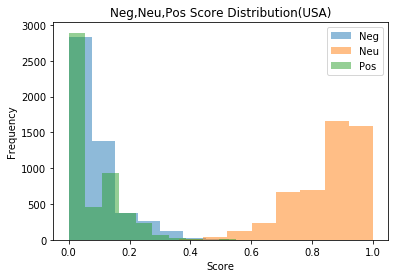

In [30]:
## Analysis for Positive, Negative and Neutral
x = dataframe['Negative']
y = dataframe['Neutral']
z = dataframe['Positive']
from matplotlib import pyplot
pyplot.hist(x, alpha=0.5, label='Neg')
pyplot.hist(y, alpha=0.5, label='Neu')
pyplot.hist(z, alpha=0.5, label='Pos')
pyplot.title('Neg,Neu,Pos Score Distribution(USA)')
pyplot.xlabel('Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

## INDIA ##

In [ ]:
## Code Chunk to extract tweets 
search_words = ['coronavirus']
## Format for geocode="lattitude,longitude,radius"
## Radius in miles km
tweets = tweepy.Cursor(api.search, search_words,
                       geocode="22.3511148,78.6677428,1000km",
                       lang="en").items(5000)
timestamp_str = []
tweet_username = []
tweet_text = []
tweet_location = []
for tweet in tweets:
    timestamp_str.append(tweet.created_at)
    tweet_username.append(tweet.user.screen_name)
    tweet_text.append(tweet.text)
## tweet.user.location will give you the general location of the user and not the particular location 
##for the tweet itself, as it turns out, most of the users do not share the exact location of the tweet
    tweet_location.append(tweet.user.location)

In [ ]:
## Convert the complied list to a Pandas Dataframe
compiled_list = {'Timestamp':timestamp_str,'User':tweet_username,'Tweet':tweet_text,'Location':tweet_location}
df = pd.DataFrame(compiled_list)

In [ ]:
## Save the Dataframe on Disk as a CSV file to avoid Loading it each time
df.to_csv('C:/Users/Ritwik/OneDrive/BZAN557/Project/India_tweets.csv')

In [31]:
## Set Working Directory
os.chdir('C:/Users/Ritwik/OneDrive/BZAN557/Project')
## Load the dataset from Disk
df_India = pd.read_csv("India_tweets.csv") 
del df_India['Unnamed: 0']

In [32]:
## Convert tweet to a list
tweet = df_India['Tweet'].values.tolist()

In [33]:
## Remove Noise around the tweets
## def clean(sentence):
    ## sentence = sentence.strip()
    ## pattern = r'[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
    ## filtered_sentence = re.sub(pattern, r' ', sentence)
    ## return filtered_sentence

In [34]:
## Use the Clean Function created above to Remove Noise Around the Tweets
tweet_clean_India = []
for ii in tweet:
    tweet_clean_India.append(clean(ii))

In [36]:
df_India['Tweet'] = tweet_clean_India

In [37]:
## Make a Wordcloud for tweets from India
wordcloud_india = ''.join(tweet_clean_India)

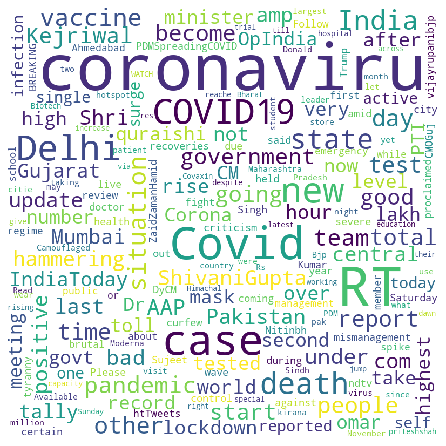

In [38]:
## We are using the original stoplist created here
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stoplist, 
                min_font_size = 10, collocations=False).generate(wordcloud_india) 
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [39]:
India_tokens = wordcloud_india.lower().strip().split()

In [40]:
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in India_tokens]

# Count word frequencies
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear even once
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
## pprint.pprint(processed_corpus)

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(8412 unique tokens: ['rt', 'pti', 'news', 'test', 'travellers']...)


In [41]:
df_word_india = pd.DataFrame.from_dict(frequency, orient="index")

In [42]:
df_word_india.index.name = 'word'
df_word_india.reset_index(inplace=True)
df_word_india.columns = ['word', 'frequency']
df_word_india.sort_values(by=['frequency'], ascending=False)

,word,frequency
6,coronavirus,2603
0,rt,1781
23,covid,1151
82,cases,1023
5,delhi,673
...,...,...
4445,tim,1
4439,iq60qg13wn,1
4438,phtdl0cvci,1
4437,a2bthjwvzz,1


In [43]:
## Filter Words with Frequence Over 100
df_word_india_100 = df_word_india[df_word_india['frequency'] > 100]  
df_word_india_100 = df_word_india_100.sort_values(by=['frequency'], ascending=False)

Text(0, 0.5, 'Most Frequent Words')

<Figure size 576x576 with 0 Axes>

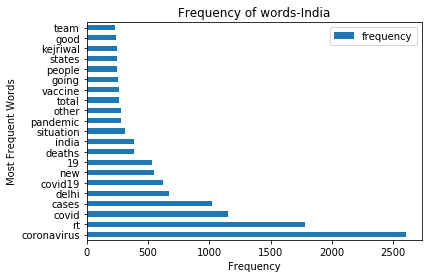

In [44]:
## Make a Bar Plot
df_word_india_most_freq = df_word_india_100[0:21]
df_word_india_most_freq = df_word_india_most_freq.set_index('word')
# Plot the figure
plt.figure(figsize=(8, 8))
fig = df_word_india_most_freq.plot(kind='barh')
fig.set_title('Frequency of words-India')
fig.set_xlabel('Frequency')
fig.set_ylabel('Most Frequent Words')

In [45]:
## Include a column with Polarity Score for Tweets
polarity_score_India = []
for ii in tweet_clean_India:
    polarity_score_India.append(TextBlob(ii).sentiment.polarity)
    
## Add the Polarity Score in the Dataframe
df_India['Polarity_Score'] = polarity_score_India

In [46]:
## Include a column with AFN Score for Tweets
afn = Afinn(emoticons=True) 
afn_score_India = []
for ii in tweet_clean_India:
    afn_score_India.append(afn.score(ii))
    
## Add the Polarity Score in the Dataframe
df_India['AFN_Score'] = afn_score_India

In [47]:
##Check
print(len(polarity_score_India))
print(len(afn_score_India))

5000
5000


Text(0.5, 1.0, 'Distrbution of Polarity Score (India)')

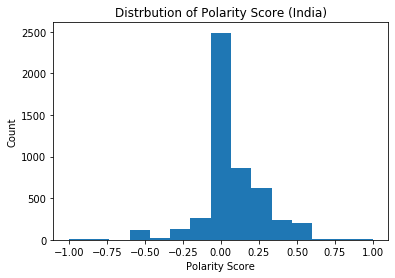

In [48]:
## Distribution of Polarity Score for India
%matplotlib inline
plt.hist(polarity_score_India, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('Polarity Score')
plt.title('Distrbution of Polarity Score (India)')

Text(0.5, 1.0, 'Distrbution of AFN Score (India)')

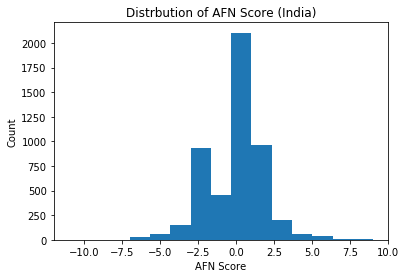

In [49]:
## Distribution of AFN Score in India
%matplotlib inline
plt.hist(afn_score_India, density = False, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('AFN Score')
plt.title('Distrbution of AFN Score (India)')

In [50]:
## Polarity Classification based on the Polarity Scores
df_India['Polarity_Classification'] = np.where(df_India['Polarity_Score'] == 0 , 'Neutral', 
                                         np.where(df_India['Polarity_Score'] >0  , 'Positive', 'Negative')) 

In [51]:
## AFN Classification based on the AFN Scores
df_India['AFN_Classification'] = np.where(df_India['AFN_Score'] == 0 , 'Neutral', 
                                         np.where(df_India['AFN_Score'] >0  , 'Positive', 'Negative')) 

In [52]:
df_India.head()

,Timestamp,User,Tweet,Location,Polarity_Score,AFN_Score,Polarity_Classification,AFN_Classification
0,2020-11-22 16:29:47,KaranDe76737049,RT PTI News UP to test all travellers from D...,NaN,0.0,0.0,Neutral,Neutral
1,2020-11-22 16:29:42,BhaskarGanekar,Don t want another lockdown but second wave ma...,Navi Mumbai,0.0,1.0,Neutral,Positive
2,2020-11-22 16:29:31,iamanurag04,raghurajs hegde So in COVID quarantine cente...,Lucknow,0.2,0.0,Positive,Neutral
3,2020-11-22 16:29:21,anandstdas,Is a year enough coronavirus https t co x...,"Bhubaneswar, India",0.0,0.0,Neutral,Neutral
4,2020-11-22 16:29:15,CoronaUpdateBot,RT PTI News UP to test all travellers from D...,NaN,0.0,0.0,Neutral,Neutral


In [53]:
## Count for Polarity Classification (India)
df_India['Polarity_Classification'].value_counts()

Positive    2277
Neutral     1820
Negative     903
Name: Polarity_Classification, dtype: int64

In [54]:
## Count for AFN Classification (India)
df_India['AFN_Classification'].value_counts()

Neutral     2104
Negative    1624
Positive    1272
Name: AFN_Classification, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

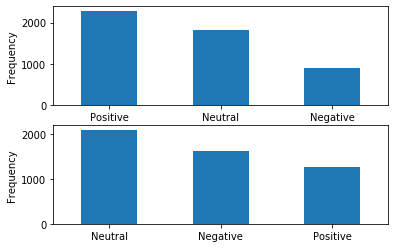

In [55]:
## Plot for Both the Classifications
## Polarity Classification Plot 
plt.subplot(2,1,1)
df_India['Polarity_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
## AFN Classification Plot
plt.subplot(2,1,2)
df_India['AFN_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

In [56]:
# Sentiment Intensity Analyzer for India
dataframe = df_India[['Timestamp','User','Tweet']].copy()
dataframe["Comp"] = ''
dataframe["Negative"] = ''
dataframe["Neutral"] = ''
dataframe["Positive"] = ''

sentiment_i_a = SentimentIntensityAnalyzer()
for index, row in df_India.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', df_India.loc[index, 'Tweet'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        dataframe.at[index, 'Comp'] = sentence_sentiment['compound']
        dataframe.at[index, 'Negative'] = sentence_sentiment['neg']
        dataframe.at[index, 'Neutral'] = sentence_sentiment['neu']
        dataframe.at[index, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (df_India.loc[index, 'Tweets'])
        print (index)

In [57]:
## Check
dataframe[0:5]

,Timestamp,User,Tweet,Comp,Negative,Neutral,Positive
0,2020-11-22 16:29:47,KaranDe76737049,RT PTI News UP to test all travellers from D...,0,0,1,0
1,2020-11-22 16:29:42,BhaskarGanekar,Don t want another lockdown but second wave ma...,0.0387,0,0.919,0.081
2,2020-11-22 16:29:31,iamanurag04,raghurajs hegde So in COVID quarantine cente...,0,0,1,0
3,2020-11-22 16:29:21,anandstdas,Is a year enough coronavirus https t co x...,0,0,1,0
4,2020-11-22 16:29:15,CoronaUpdateBot,RT PTI News UP to test all travellers from D...,0,0,1,0


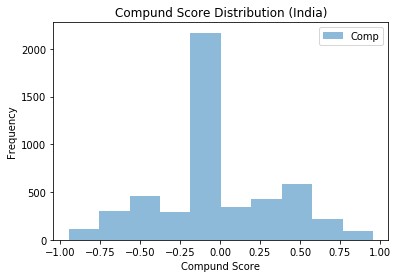

In [58]:
## Compound Score Distribution for India
w = dataframe['Comp']
from matplotlib import pyplot
pyplot.hist(w, alpha=0.5, label='Comp')
pyplot.title('Compund Score Distribution (India)')
pyplot.xlabel('Compund Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

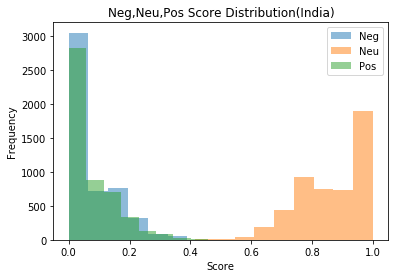

In [59]:
## Analysis for Positive, Negative and Neutral
x = dataframe['Negative']
y = dataframe['Neutral']
z = dataframe['Positive']
from matplotlib import pyplot
pyplot.hist(x, alpha=0.5, label='Neg')
pyplot.hist(y, alpha=0.5, label='Neu')
pyplot.hist(z, alpha=0.5, label='Pos')
pyplot.title('Neg,Neu,Pos Score Distribution(India)')
pyplot.xlabel('Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

## Brazil ##

In [ ]:
## Code Chunk to extract tweets 
search_words = ['coronavirus']
## Format for geocode="lattitude,longitude,radius"
## Radius should be in miles or km
tweets = tweepy.Cursor(api.search, search_words,
                       geocode="-23.533773,-46.625290,2000km",
                       lang="en").items(5000)
timestamp_str = []
tweet_username = []
tweet_text = []
tweet_location = []
for tweet in tweets:
    timestamp_str.append(tweet.created_at)
    tweet_username.append(tweet.user.screen_name)
    tweet_text.append(tweet.text)
## tweet.user.location will give you the general location of the user and not the particular location 
##for the tweet itself, as it turns out, most of the users do not share the exact location of the tweet
    tweet_location.append(tweet.user.location)

In [ ]:
## Convert the complied list to a Pandas Dataframe
compiled_list = {'Timestamp':timestamp_str,'User':tweet_username,'Tweet':tweet_text,'Location':tweet_location}
df = pd.DataFrame(compiled_list)

In [ ]:
## Save the Dataframe on Disk as a CSV file to avoid Loading it each time
df.to_csv('C:/Users/Ritwik/OneDrive/BZAN557/Project/Brazil_tweets.csv')

In [60]:
## Set Working Directory
os.chdir('C:/Users/Ritwik/OneDrive/BZAN557/Project')
## Load the dataset from Disk
df_Brazil = pd.read_csv("Brazil_tweets.csv") 
del df_Brazil['Unnamed: 0']

In [61]:
## Convert tweet to a list
tweet_Brazil = df_Brazil['Tweet'].values.tolist()

In [62]:
## Remove Noise around the tweets
# def clean(sentence):
    # sentence = sentence.strip()
    # pattern = r'[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
    # filtered_sentence = re.sub(pattern, r' ', sentence)
    # return filtered_sentence

In [63]:
## Use the function above to clean the tweet (Remove Noise around tweet)
tweet_clean_Brazil = []
for ii in tweet_Brazil:
    tweet_clean_Brazil.append(clean(ii))

In [64]:
## Copy to the dataframe
df_Brazil['Tweet'] = tweet_clean_Brazil

In [65]:
## Make a Wordcloud
wordcloud_Brazil = ''.join(tweet_clean_Brazil)

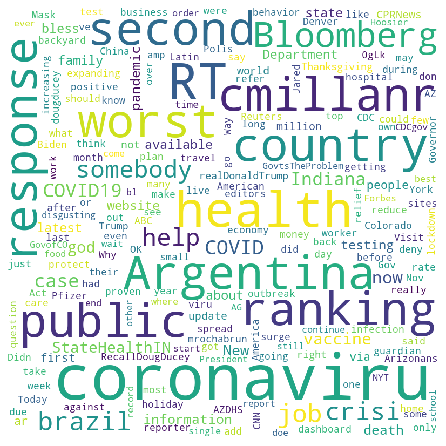

In [66]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stoplist, 
                min_font_size = 10, collocations=False).generate(wordcloud_Brazil) 

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [67]:
Brazil_tokens = wordcloud_Brazil.lower().strip().split()

In [68]:
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in Brazil_tokens]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear even once
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
## pprint.pprint(processed_corpus)

from gensim import corpora

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(7912 unique tokens: ['rt', 'howardpelling', 'trump', 'repub', 'voter']...)


In [69]:
df_word_brazil = pd.DataFrame.from_dict(frequency, orient="index")

In [70]:
## Analyze the most frequent words in the Brazil tweets dataframe
df_word_brazil.index.name = 'word'
df_word_brazil.reset_index(inplace=True)
df_word_brazil.columns = ['word', 'frequency']
df_word_brazil.sort_values(by=['frequency'], ascending=False)

,word,frequency
11,coronavirus,3071
0,rt,1840
266,health,1721
393,argentina,1529
165,public,1522
...,...,...
3834,473,1
3833,534,1
3832,562,1
3830,865,1


In [71]:
## Filter Words with Frequence Over 100
df_word_brazil_100 = df_word_brazil[df_word_brazil['frequency'] > 100]  
df_word_brazil_100= df_word_brazil_100.sort_values(by=['frequency'], ascending=False)

Text(0, 0.5, 'Most Frequent Words')

<Figure size 576x576 with 0 Axes>

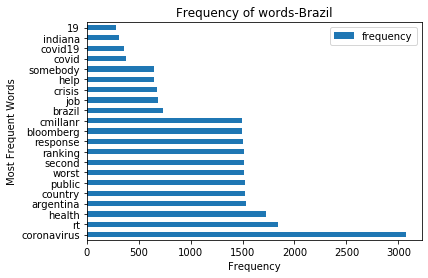

In [72]:
## Make a Bar Plot
df_word_brazil_most_freq = df_word_brazil_100[0:21]
df_word_brazil_most_freq = df_word_brazil_most_freq.set_index('word')

# Plot the figure.
plt.figure(figsize=(8, 8))
fig = df_word_brazil_most_freq.plot(kind='barh')
fig.set_title('Frequency of words-Brazil')
fig.set_xlabel('Frequency')
fig.set_ylabel('Most Frequent Words')

In [73]:
## Include a column with Polarity Score for Tweets
polarity_score_Brazil = []
for ii in tweet_clean_Brazil:
    polarity_score_Brazil.append(TextBlob(ii).sentiment.polarity)
    
## Add the Polarity Score in the Dataframe
df_Brazil['Polarity_Score'] = polarity_score_Brazil

In [74]:
## Include a column with AFN Score for Tweets
afn = Afinn(emoticons=True) 
afn_score_Brazil = []
for ii in tweet_clean_Brazil:
    afn_score_Brazil.append(afn.score(ii))
    
## Add the Polarity Score in the Dataframe
df_Brazil['AFN_Score'] = afn_score_Brazil

In [75]:
##Check
print(len(polarity_score_Brazil))
print(len(afn_score_Brazil))

4805
4805


Text(0.5, 1.0, 'Distribution of Polarity Score (Brazil)')

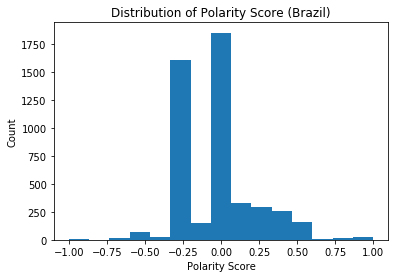

In [76]:
## Distribution of Polarity Score for Brazil
%matplotlib inline
plt.hist(polarity_score_Brazil, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('Polarity Score')
plt.title('Distribution of Polarity Score (Brazil)')

Text(0.5, 1.0, 'Distribution of AFN Score (Brazil)')

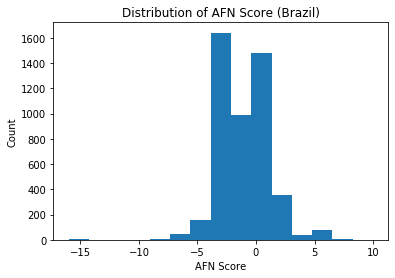

In [77]:
## Distribution of AFN Score for Brazil
%matplotlib inline
plt.hist(afn_score_Brazil, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('AFN Score')
plt.title('Distribution of AFN Score (Brazil)')

In [78]:
## Polarity Classification based on the Polarity Scores
df_Brazil['Polarity_Classification'] = np.where(df_Brazil['Polarity_Score'] == 0 , 'Neutral', 
                                         np.where(df_Brazil['Polarity_Score'] >0  , 'Positive', 'Negative')) 

In [79]:
## Polarity Classification based on the AFN Scores
df_Brazil['AFN_Classification'] = np.where(df_Brazil['AFN_Score'] == 0 , 'Neutral', 
                                         np.where(df_Brazil['AFN_Score'] >0  , 'Positive', 'Negative')) 

In [80]:
## Count for Polarity Classification (Brazil)
df_Brazil['Polarity_Classification'].value_counts()

Negative    1944
Neutral     1697
Positive    1164
Name: Polarity_Classification, dtype: int64

In [81]:
## Count for Polarity Classification (Brazil)
df_Brazil['AFN_Classification'].value_counts()

Negative    2850
Neutral     1158
Positive     797
Name: AFN_Classification, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

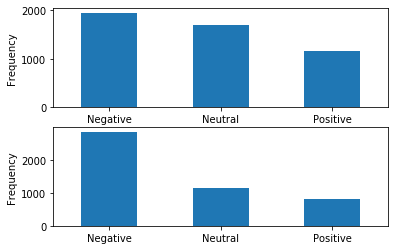

In [82]:
## Plot for Both the Classifications
## Polarity Classification Plot
plt.subplot(2,1,1)
df_Brazil['Polarity_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
## AFN Classification Plot
plt.subplot(2,1,2)
df_Brazil['AFN_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

In [83]:
# Sentiment Intensity Analyzer for Brazil
dataframe = df_Brazil[['Timestamp','User','Tweet']].copy()
dataframe["Comp"] = ''
dataframe["Negative"] = ''
dataframe["Neutral"] = ''
dataframe["Positive"] = ''

sentiment_i_a = SentimentIntensityAnalyzer()
for index, row in df_Brazil.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', df_Brazil.loc[index, 'Tweet'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        dataframe.at[index, 'Comp'] = sentence_sentiment['compound']
        dataframe.at[index, 'Negative'] = sentence_sentiment['neg']
        dataframe.at[index, 'Neutral'] = sentence_sentiment['neu']
        dataframe.at[index, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (df_Brazil.loc[index, 'Tweets'])
        print (index)

In [84]:
## Check
dataframe[0:5]

,Timestamp,User,Tweet,Comp,Negative,Neutral,Positive
0,2020-12-03 22:16:07,leass_p,RT howardpelling Trump repub voter base ...,0.2111,0.098,0.759,0.143
1,2020-12-03 22:11:13,HRM101188,RT realryanhartwig I have a few questions ...,0,0,1,0
2,2020-12-03 22:03:54,howardpelling,Trump repub voter base Older Comorbiditi...,0.2111,0.093,0.772,0.136
3,2020-12-03 22:02:44,hatelinguica,US coronavirus The nation has reported its hi...,-0.5994,0.157,0.843,0
4,2020-12-03 22:00:45,BluePhoenix167,RT SenatorBennet As COVID19 cases continue ...,-0.5423,0.247,0.674,0.079


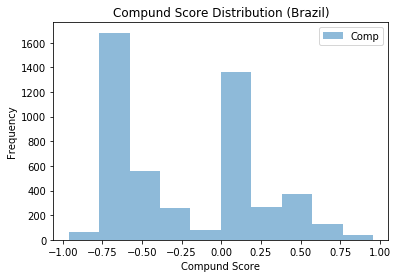

In [85]:
## Compound Score Distribution for Brazil
w = dataframe['Comp']
pyplot.hist(w, alpha=0.5, label='Comp')
pyplot.title('Compund Score Distribution (Brazil)')
pyplot.xlabel('Compund Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

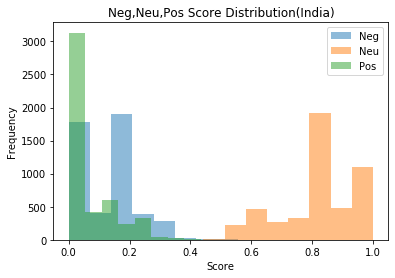

In [86]:
## Analysis for Positive, Negative and Neutral
x = dataframe['Negative']
y = dataframe['Neutral']
z = dataframe['Positive']
from matplotlib import pyplot
pyplot.hist(x, alpha=0.5, label='Neg')
pyplot.hist(y, alpha=0.5, label='Neu')
pyplot.hist(z, alpha=0.5, label='Pos')
pyplot.title('Neg,Neu,Pos Score Distribution(India)')
pyplot.xlabel('Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

## Mexcio ##

In [ ]:
## Code Chunk to extract tweets 
search_words = ['coronavirus']
## Format for geocode="lattitude,longitude,radius"
## Radius should be in miles or km
tweets = tweepy.Cursor(api.search, search_words,
                       geocode="21.85802,-102.29533,1000km",
                       lang="en").items(5000)
timestamp_str = []
tweet_username = []
tweet_text = []
tweet_location = []
for tweet in tweets:
    timestamp_str.append(tweet.created_at)
    tweet_username.append(tweet.user.screen_name)
    tweet_text.append(tweet.text)
## tweet.user.location will give you the general location of the user and not the particular location 
##for the tweet itself, as it turns out, most of the users do not share the exact location of the tweet
    tweet_location.append(tweet.user.location)

In [ ]:
## Convert the complied list to a Pandas Dataframe
compiled_list = {'Timestamp':timestamp_str,'User':tweet_username,'Tweet':tweet_text,'Location':tweet_location}
df = pd.DataFrame(compiled_list)

In [ ]:
## Save the Dataframe on Disk as a CSV file to avoid Loading it each time
df.to_csv('C:/Users/Ritwik/OneDrive/BZAN557/Project/Mexico_tweets.csv')

In [87]:
## Set Working Directory
os.chdir('C:/Users/Ritwik/OneDrive/BZAN557/Project')
## Load the dataset from Disk
df_Mexico = pd.read_csv("Mexico_tweets.csv") 
del df_Mexico['Unnamed: 0']

In [88]:
## Convert tweet to a list
tweet_Mexico = df_Mexico['Tweet'].values.tolist()

In [89]:
## Remove Noise around the tweets
## def clean(sentence):
    ## sentence = sentence.strip()
    ## pattern = r'[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
    ## filtered_sentence = re.sub(pattern, r' ', sentence)
    ## return filtered_sentence

In [90]:
## Use the above function to clean the tweets or Remove Noise around the tweets
tweet_clean_Mexico = []
for ii in tweet_Mexico:
    tweet_clean_Mexico.append(clean(ii))

In [91]:
df_Mexico['Tweet'] = tweet_clean_Mexico

In [92]:
## Make a Wordcloud for tweets from Mexico
wordcloud_Mexico = ''.join(tweet_clean_Mexico)

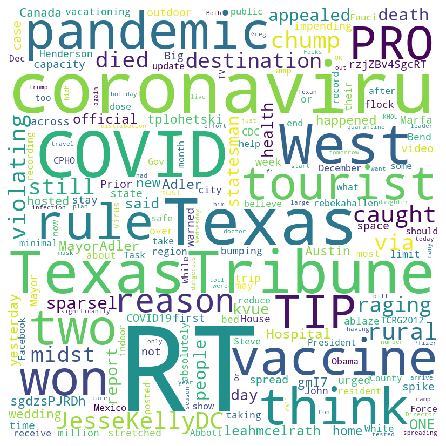

In [93]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stoplist, 
                min_font_size = 10, collocations=False).generate(wordcloud_Mexico) 

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [94]:
Mexico_tokens = wordcloud_Mexico.lower().strip().split()

In [95]:
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in Mexico_tokens]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear even once
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
## pprint.pprint(processed_corpus)

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(6563 unique tokens: ['0etpyyxubgformer', 'presidents', 'barackobama', 'george', 'w']...)


In [96]:
df_word_mexico = pd.DataFrame.from_dict(frequency, orient="index")

In [97]:
df_word_mexico.index.name = 'word'
df_word_mexico.reset_index(inplace=True)
df_word_mexico.columns = ['word', 'frequency']
df_word_mexico.sort_values(by=['frequency'], ascending=False)

,word,frequency
62,rt,2404
19,coronavirus,1237
123,texas,1027
47,covid,985
48,19,861
...,...,...
3417,clea,1
3418,qdskhk0f1cthe,1
3419,marcos,1
3421,agencies,1


In [98]:
## Filter Words with Frequence Over 100
df_word_mexico_100 = df_word_mexico[df_word_mexico['frequency'] > 100]  
df_word_mexico_100= df_word_mexico_100.sort_values(by=['frequency'], ascending=False)

Text(0, 0.5, 'Most Frequent Words')

<Figure size 576x576 with 0 Axes>

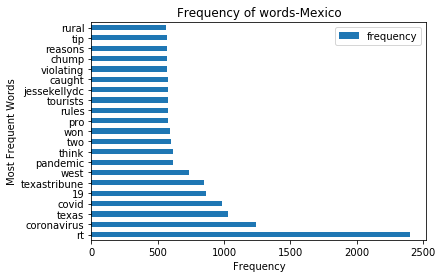

In [99]:
## Make a Bar Plot
df_word_mexico_most_freq = df_word_mexico_100[0:21]
df_word_mexico_most_freq = df_word_mexico_most_freq.set_index('word')

# Plot the figure.
plt.figure(figsize=(8, 8))
fig = df_word_mexico_most_freq.plot(kind='barh')
fig.set_title('Frequency of words-Mexico')
fig.set_xlabel('Frequency')
fig.set_ylabel('Most Frequent Words')

In [100]:
## Include a column with Polarity Score for Tweets
polarity_score_Mexico = []
for ii in tweet_clean_Mexico:
    polarity_score_Mexico.append(TextBlob(ii).sentiment.polarity)
    
## Add the Polarity Score in the Dataframe
df_Mexico['Polarity_Score'] = polarity_score_Mexico

In [101]:
## Include a column with AFN Score for Tweets
afn = Afinn(emoticons=True) 
afn_score_Mexico = []
for ii in tweet_clean_Mexico:
    afn_score_Mexico.append(afn.score(ii))
    
## Add the Polarity Score in the Dataframe
df_Mexico['AFN_Score'] = afn_score_Mexico

In [102]:
##Check
print(len(polarity_score_Mexico))
print(len(afn_score_Mexico))

5000
5000


Text(0.5, 1.0, 'Distribution of Polarity Score (Mexico)')

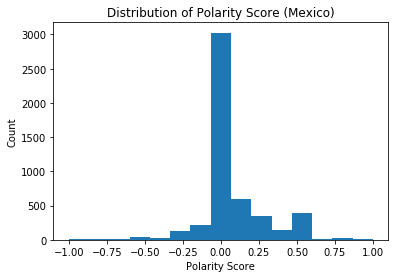

In [103]:
## Distribution of Polarity Score for Mexico
%matplotlib inline
plt.hist(polarity_score_Mexico, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('Polarity Score')
plt.title('Distribution of Polarity Score (Mexico)')

Text(0.5, 1.0, 'Distribution of AFN Score (Mexico)')

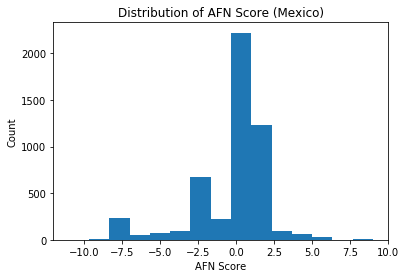

In [104]:
## Distribution of AFN Score for Mexico
%matplotlib inline
plt.hist(afn_score_Mexico, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('AFN Score')
plt.title('Distribution of AFN Score (Mexico)')

In [105]:
## Polarity Classification based on the Polarity Scores
df_Mexico['Polarity_Classification'] = np.where(df_Mexico['Polarity_Score'] == 0 , 'Neutral', 
                                         np.where(df_Mexico['Polarity_Score'] >0  , 'Positive', 'Negative')) 

In [106]:
## Polarity Classification based on the AFN Scores
df_Mexico['AFN_Classification'] = np.where(df_Mexico['AFN_Score'] == 0 , 'Neutral', 
                                         np.where(df_Mexico['AFN_Score'] >0  , 'Positive', 'Negative')) 

In [107]:
## Count for Polarity Classification (Mexico)
df_Mexico['Polarity_Classification'].value_counts()

Neutral     2732
Positive    1643
Negative     625
Name: Polarity_Classification, dtype: int64

In [108]:
## Count for Polarity Classification (Mexico)
df_Mexico['AFN_Classification'].value_counts()

Neutral     2222
Positive    1431
Negative    1347
Name: AFN_Classification, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

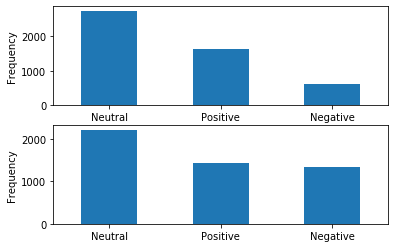

In [109]:
## Plot for Both the Classifications
## Plot for Polarity Classification
plt.subplot(2,1,1)
df_Mexico['Polarity_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
## Plot for AFN Classification
plt.subplot(2,1,2)
df_Mexico['AFN_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

In [110]:
# Sentiment Intensity Analyzer for Mexico
dataframe = df_Mexico[['Timestamp','User','Tweet']].copy()
dataframe["Comp"] = ''
dataframe["Negative"] = ''
dataframe["Neutral"] = ''
dataframe["Positive"] = ''

sentiment_i_a = SentimentIntensityAnalyzer()
for index, row in df_Mexico.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', df_Mexico.loc[index, 'Tweet'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        dataframe.at[index, 'Comp'] = sentence_sentiment['compound']
        dataframe.at[index, 'Negative'] = sentence_sentiment['neg']
        dataframe.at[index, 'Neutral'] = sentence_sentiment['neu']
        dataframe.at[index, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (df_Mexico.loc[index, 'Tweets'])
        print (index)

In [111]:
## Check
dataframe[0:5]

,Timestamp,User,Tweet,Comp,Negative,Neutral,Positive
0,2020-12-03 19:20:03,KXAN_News,We can do this and we need to do this http...,0,0,1,0
1,2020-12-03 19:19:18,KVUE,Former Presidents BarackObama George W Bush...,0,0,1,0
2,2020-12-03 19:18:59,Sparkydoggo,RT NewsbreakCanada Smith Mike5 macmastermk...,-0.3818,0.14,0.86,0
3,2020-12-03 19:18:58,MelissaNoriega,What the heck is WRONG W people Do you REALL...,-0.5904,0.138,0.862,0
4,2020-12-03 19:18:57,BKINGnyg,RT tplohetski Here is my report via statesm...,0,0,1,0


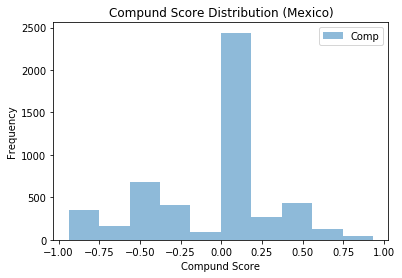

In [112]:
## Compound Score Distribution for Mexico
w = dataframe['Comp']
pyplot.hist(w, alpha=0.5, label='Comp')
pyplot.title('Compund Score Distribution (Mexico)')
pyplot.xlabel('Compund Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

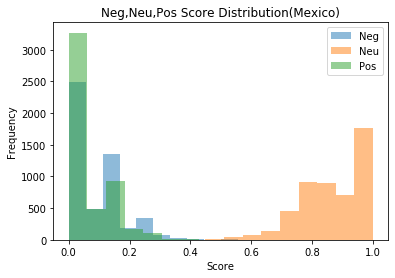

In [113]:
## Analysis for Positive, Negative and Neutral
x = dataframe['Negative']
y = dataframe['Neutral']
z = dataframe['Positive']
from matplotlib import pyplot
pyplot.hist(x, alpha=0.5, label='Neg')
pyplot.hist(y, alpha=0.5, label='Neu')
pyplot.hist(z, alpha=0.5, label='Pos')
pyplot.title('Neg,Neu,Pos Score Distribution(Mexico)')
pyplot.xlabel('Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

## United Kingdom ##

In [ ]:
## Code Chunk to extract tweets 
search_words = ['coronavirus']
## Format for geocode="lattitude,longitude,radius"
## Radius should be in miles or km
tweets = tweepy.Cursor(api.search, search_words,
                       geocode="58.35,-6.35,2500km",
                       lang="en").items(5000)
timestamp_str = []
tweet_username = []
tweet_text = []
tweet_location = []
for tweet in tweets:
    timestamp_str.append(tweet.created_at)
    tweet_username.append(tweet.user.screen_name)
    tweet_text.append(tweet.text)
## tweet.user.location will give you the general location of the user and not the particular location 
##for the tweet itself, as it turns out, most of the users do not share the exact location of the tweet
    tweet_location.append(tweet.user.location)

In [ ]:
## Convert the complied list to a Pandas Dataframe
compiled_list = {'Timestamp':timestamp_str,'User':tweet_username,'Tweet':tweet_text,'Location':tweet_location}
df = pd.DataFrame(compiled_list)

In [ ]:
## Save the Dataframe on Disk as a CSV file to avoid Loading it each time
df.to_csv('C:/Users/Ritwik/OneDrive/BZAN557/Project/UK_tweets.csv')

In [114]:
## Set Working Directory
os.chdir('C:/Users/Ritwik/OneDrive/BZAN557/Project')
## Load the dataset from Disk
df_UK = pd.read_csv("UK_tweets.csv") 
del df_UK['Unnamed: 0']

In [115]:
## Convert tweet to a list
tweet_UK = df_UK['Tweet'].values.tolist()

In [116]:
## Remove Noise around the tweets
# def clean(sentence):
    # sentence = sentence.strip()
    # pattern = r'[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
    # filtered_sentence = re.sub(pattern, r' ', sentence)
    # return filtered_sentence

In [117]:
## Use the above function to clean the extracted tweets (Remove the Noise)
tweet_clean_UK = []
for ii in tweet_UK:
    tweet_clean_UK.append(clean(ii))

In [118]:
## Copy the cleaned tweets in the dataframe
df_UK['Tweet'] = tweet_clean_UK

In [119]:
## Make a wordcloud for UK Tweets
wordcloud_UK = ''.join(tweet_clean_UK)

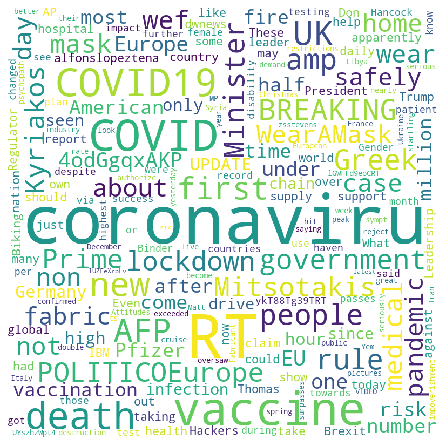

In [120]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stoplist, 
                min_font_size = 10, collocations=False).generate(wordcloud_UK) 

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [121]:
UK_tokens = wordcloud_UK.lower().strip().split()

In [122]:
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in UK_tokens]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear even once
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
## pprint.pprint(processed_corpus)

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(9095 unique tokens: ['sars', 'news', 'bcan4zxzaart', 'marionkoopmans', 'names']...)


In [123]:
df_word_UK = pd.DataFrame.from_dict(frequency, orient="index")

In [124]:
df_word_UK.index.name = 'word'
df_word_UK.reset_index(inplace=True)
df_word_UK.columns = ['word', 'frequency']
df_word_UK.sort_values(by=['frequency'], ascending=False)

,word,frequency
9,coronavirus,2082
63,rt,1679
177,vaccine,796
175,covid,755
122,covid19,584
...,...,...
4761,missjamirocat,1
4760,hvxgfklubx,1
4759,lzpxlm9tauthe,1
4755,yue5vu8ka8rt,1


In [125]:
## Filter Words with Frequence Over 100
df_word_UK_100 = df_word_UK[df_word_UK['frequency'] > 100]  
df_word_UK_100= df_word_UK_100.sort_values(by=['frequency'], ascending=False)

Text(0, 0.5, 'Most Frequent Words')

<Figure size 576x576 with 0 Axes>

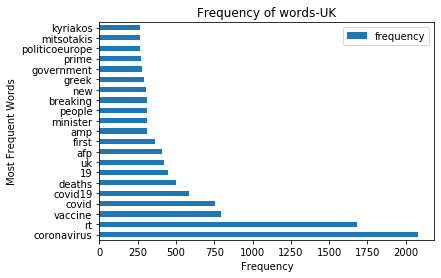

In [126]:
## Make a Bar Plot
df_word_UK_most_freq = df_word_UK_100[0:21]
df_word_UK_most_freq = df_word_UK_most_freq.set_index('word')

# Plot the figure.
plt.figure(figsize=(8, 8))
fig = df_word_UK_most_freq.plot(kind='barh')
fig.set_title('Frequency of words-UK')
fig.set_xlabel('Frequency')
fig.set_ylabel('Most Frequent Words')

In [127]:
## Include a column with Polarity Score for Tweets
polarity_score_UK = []
for ii in tweet_clean_UK:
    polarity_score_UK.append(TextBlob(ii).sentiment.polarity)
    
## Add the Polarity Score in the Dataframe
df_UK['Polarity_Score'] = polarity_score_UK

In [128]:
## Include a column with AFN Score for Tweets
afn = Afinn(emoticons=True) 
afn_score_UK = []
for ii in tweet_clean_UK:
    afn_score_UK.append(afn.score(ii))
    
## Add the Polarity Score in the Dataframe
df_UK['AFN_Score'] = afn_score_UK

In [129]:
##Check
print(len(polarity_score_UK))
print(len(afn_score_UK))

5000
5000


Text(0.5, 1.0, 'Distribution of Polarity Score (UK)')

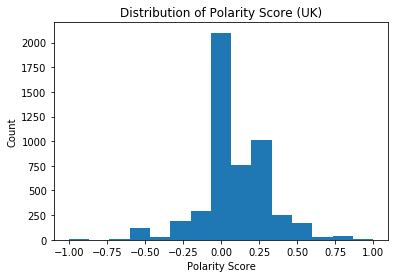

In [130]:
## Distribution of Polarity Score for UK
%matplotlib inline
plt.hist(polarity_score_UK, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('Polarity Score')
plt.title('Distribution of Polarity Score (UK)')

Text(0.5, 1.0, 'Distribution of AFN Score (UK)')

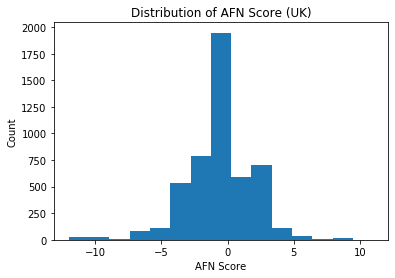

In [131]:
## Distribution of AFN Score for UK
%matplotlib inline
plt.hist(afn_score_UK, bins=15)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('AFN Score')
plt.title('Distribution of AFN Score (UK)')

In [132]:
## Polarity Classification based on the Polarity Scores
df_UK['Polarity_Classification'] = np.where(df_UK['Polarity_Score'] == 0 , 'Neutral', 
                                         np.where(df_UK['Polarity_Score'] >0  , 'Positive', 'Negative')) 

In [133]:
## AFN Classification based on the AFN Scores
df_UK['AFN_Classification'] = np.where(df_UK['AFN_Score'] == 0 , 'Neutral', 
                                         np.where(df_UK['AFN_Score'] >0  , 'Positive', 'Negative')) 

In [134]:
## Polarity Type Count for UK Tweets 
df_UK['Polarity_Classification'].value_counts()

Positive    2395
Neutral     1737
Negative     868
Name: Polarity_Classification, dtype: int64

In [135]:
## AFN Type Count for UK Tweets 
df_UK['AFN_Classification'].value_counts()

Negative    1931
Neutral     1592
Positive    1477
Name: AFN_Classification, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

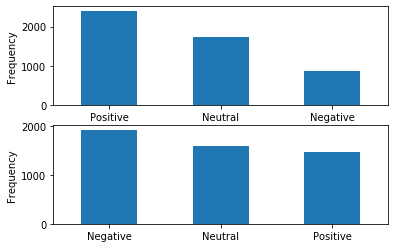

In [136]:
## Plot for Both the Classifications
## Plot for Polarity Classification
plt.subplot(2,1,1)
df_UK['Polarity_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
## Plot for AFN Classification
plt.subplot(2,1,2)
df_UK['AFN_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

In [137]:
# Sentiment Intensity Analyzer for UK
dataframe = df_UK[['Timestamp','User','Tweet']].copy()
dataframe["Comp"] = ''
dataframe["Negative"] = ''
dataframe["Neutral"] = ''
dataframe["Positive"] = ''

sentiment_i_a = SentimentIntensityAnalyzer()
for index, row in df_UK.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', df_UK.loc[index, 'Tweet'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        dataframe.at[index, 'Comp'] = sentence_sentiment['compound']
        dataframe.at[index, 'Negative'] = sentence_sentiment['neg']
        dataframe.at[index, 'Neutral'] = sentence_sentiment['neu']
        dataframe.at[index, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (df_UK.loc[index, 'Tweets'])
        print (index)

In [138]:
dataframe[0:5]

,Timestamp,User,Tweet,Comp,Negative,Neutral,Positive
0,2020-12-04 00:03:46,HansSars,Sars News https t co bCAN4ZxzaA,0,0,1,0
1,2020-12-04 00:02:59,philosophylinks,RT MarionKoopmans WHO names line up for inte...,0,0,1,0
2,2020-12-04 00:02:14,btcty,Megathread on Pharma Why you can t trust big ...,0.5106,0,0.875,0.125
3,2020-12-04 00:00:50,AmyChaos,RT WHO Support people with disability by ta...,-0.3612,0.241,0.669,0.09
4,2020-12-04 00:00:27,RAADARde,Warner Bros Says All 2021 Films Will be Strea...,0,0,1,0


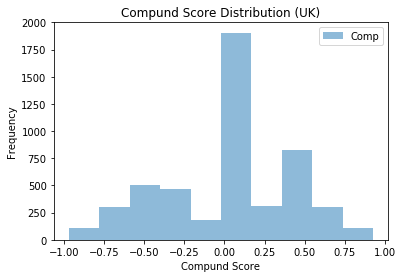

In [139]:
## Compound Score Distribution for UK
w = dataframe['Comp']
pyplot.hist(w, alpha=0.5, label='Comp')
pyplot.title('Compund Score Distribution (UK)')
pyplot.xlabel('Compund Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

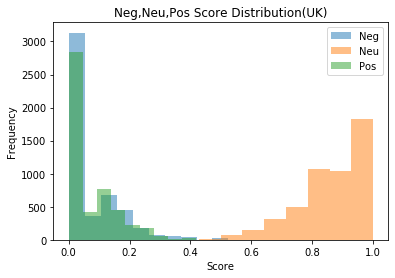

In [140]:
## Analysis for Positive, Negative and Neutral
x = dataframe['Negative']
y = dataframe['Neutral']
z = dataframe['Positive']
from matplotlib import pyplot
pyplot.hist(x, alpha=0.5, label='Neg')
pyplot.hist(y, alpha=0.5, label='Neu')
pyplot.hist(z, alpha=0.5, label='Pos')
pyplot.title('Neg,Neu,Pos Score Distribution(UK)')
pyplot.xlabel('Score')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper right')
pyplot.show()

## ALL TWEETS TOGETHER (FOR USA, INDIA, BRAZIL, MEXICO, UK)

Worcloud for all tweets togther

In [141]:
## Make a Wordcloud for all tweets combined together
## Combine all the text/tweets together
wordcloud_all = wordcloud_usa + wordcloud_india + wordcloud_Brazil + wordcloud_Mexico + wordcloud_UK

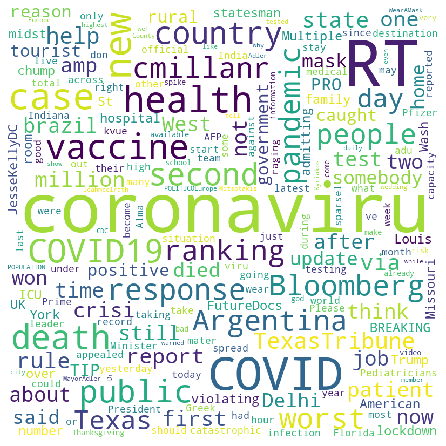

In [142]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stoplist, 
                min_font_size = 10, collocations=False).generate(wordcloud_all) 
## Plot the Wordcloud
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Exploring Word Term Frequency for Each Country

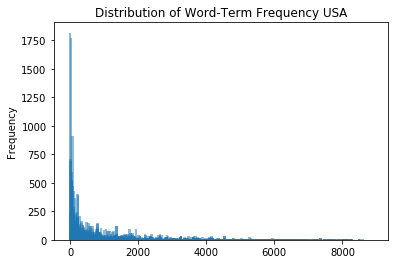

In [143]:
## USA
term_rank_1 = np.arange(len(df_word_usa)) + 1
# basic bars
plt.bar(term_rank_1, df_word_usa['frequency'], align='center',width = 75,alpha=0.5)
plt.title('Distribution of Word-Term Frequency USA')
plt.ylabel('Frequency')
plt.show()

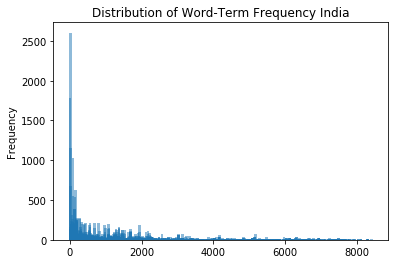

In [144]:
## India
term_rank_2 = np.arange(len(df_word_india)) + 1
# basic bars
plt.bar(term_rank_2, df_word_india['frequency'], align='center',width = 75,alpha=0.5)
plt.title('Distribution of Word-Term Frequency India')
plt.ylabel('Frequency')
plt.show()

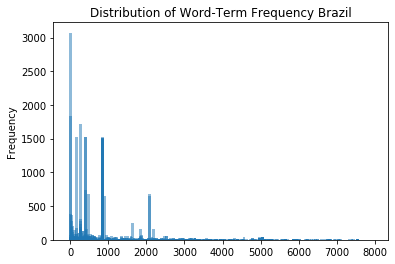

In [145]:
## Brazil
term_rank_3 = np.arange(len(df_word_brazil)) + 1
# basic bars
plt.bar(term_rank_3, df_word_brazil['frequency'], align='center',width = 75,alpha=0.5)
plt.title('Distribution of Word-Term Frequency Brazil')
plt.ylabel('Frequency')
plt.show()

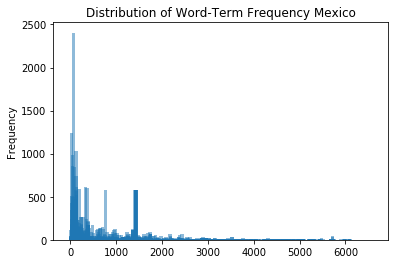

In [146]:
## Mexico
term_rank_4 = np.arange(len(df_word_mexico)) + 1
# basic bars
plt.bar(term_rank_4, df_word_mexico['frequency'], align='center',width = 75,alpha=0.5)
plt.title('Distribution of Word-Term Frequency Mexico')
plt.ylabel('Frequency')
plt.show()

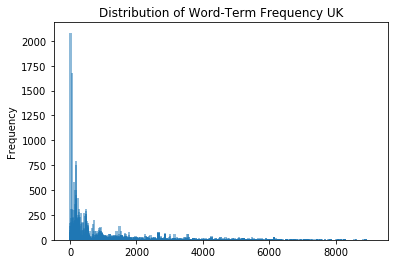

In [147]:
## United Kingdom
term_rank_5 = np.arange(len(df_word_UK)) + 1
# basic bars
plt.bar(term_rank_5, df_word_UK['frequency'], align='center',width = 75,alpha=0.5)
plt.title('Distribution of Word-Term Frequency UK')
plt.ylabel('Frequency')
plt.show()

Add all the dataframes together

In [148]:
frames = [df_usa, df_India, df_Brazil, df_Mexico, df_UK]

In [149]:
## Dataframe with all entries from 5 countries
result = pd.concat(frames)

In [150]:
## Check -- 5000 + 5000 + 4805 + 5000 + 5000
len(result)

24805

In [151]:
## Polarity Type Count for ALL Tweets 
result['Polarity_Classification'].value_counts()

Neutral     9921
Positive    9642
Negative    5242
Name: Polarity_Classification, dtype: int64

In [152]:
## AFN Type Count for ALL Tweets 
result['AFN_Classification'].value_counts()

Negative    10075
Neutral      8596
Positive     6134
Name: AFN_Classification, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

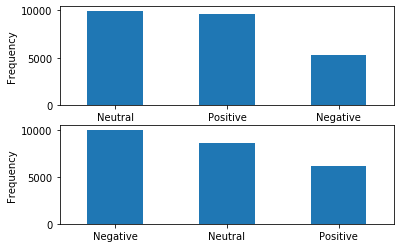

In [153]:
## Plot for Both the Classifications
## Plot for Polarity Classification
plt.subplot(2,1,1)
result['Polarity_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
## Plot for AFN Classification
plt.subplot(2,1,2)
result['AFN_Classification'].value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

## Make a Text Corpus ##

In [154]:
## Make a Text Corpus
text_corpus = usa_tokens + India_tokens + Brazil_tokens + Mexico_tokens + UK_tokens

In [155]:
len(text_corpus)

522274

In [156]:
## Make a Dictionary with all the Tweets
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in text_corpus]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear even once
processed_corpus = [[token for token in text if frequency[token] > 0] for text in texts]
## pprint.pprint(processed_corpus)

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(28742 unique tokens: ['rt', 'colmorrisdavis', 'national', 'debt', '27']...)


In [157]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

Gensim Model for the entire text corpus

In [158]:
import gensim
model = gensim.models.Word2Vec(processed_corpus, size =500)

In [159]:
## 'Positive words with Covid' alone
print(model.wv.most_similar(positive=['covid']))

[('matinastevis', 0.16633717715740204), ('compare', 0.1571330428123474), ('pay', 0.1540391445159912), ('symptoms', 0.15119943022727966), ('alberta', 0.14492008090019226), ('schiphol', 0.14476655423641205), ('animals', 0.13985216617584229), ('van', 0.13598749041557312), ('grocery', 0.13416539132595062), ('coverings', 0.13415321707725525)]


In [160]:
## 'Positive words with Covid' alone
print(model.wv.most_similar(positive=['coronavirus']))

[('tplohetski', 0.15922996401786804), ('stop', 0.15643975138664246), ('murphy', 0.14629754424095154), ('language', 0.1453494429588318), ('ryanmlowery', 0.1424812227487564), ('hillelneuer', 0.14077740907669067), ('accuses', 0.13737301528453827), ('punjab', 0.13687971234321594), ('happened', 0.1358688920736313), ('dna', 0.13525554537773132)]


## LDA Model ##

Here we fit an LDA model on all the Tweets 

In [161]:
## Extract tweets from all the countries
## USA
df1 = df_usa.Tweet.values.tolist()
## India
df2 = df_India.Tweet.values.tolist()
## Brazil
df3 = df_Brazil.Tweet.values.tolist()
## Mexico
df4 = df_Mexico.Tweet.values.tolist()
## United Kingdom
df5 = df_UK.Tweet.values.tolist()

In [162]:
## Combine all of it into one list
data = df1 + df2 + df3 + df4 + df5

In [163]:
## Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [164]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [165]:
print(data[:1])

['RT ColMorrisDavis The national debt is 27 248 063 291 167 255 909 American lives have been lost to Covid 19 Trump played golf for the ']


In [166]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['rt', 'colmorrisdavis', 'the', 'national', 'debt', 'is', 'american', 'lives', 'have', 'been', 'lost', 'to', 'covid', 'trump', 'played', 'golf', 'for', 'the']]


In [167]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams[:2])

[['rt', 'colmorrisdavis', 'the', 'national', 'debt', 'is', 'american', 'lives', 'have', 'been', 'lost', 'to', 'covid', 'trump', 'played', 'golf', 'for', 'the'], ['rt', 'eagle', 'ascending', 'ben_carson', 'says', 'he', 'out', 'of', 'the', 'woods', 'after', 'taking', 'an', 'unproven', 'coronavirus', 'treatment', 'recommended', 'by', 'the', 'mypillow', 'ceo']]


In [168]:
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
     doc = nlp(" ".join(sent))
     texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

data_lemmatized = lemmatization(data_words_bigrams)
print(data_lemmatized[:2])

[['national', 'debt', 'american', 'life', 'lose', 'covid', 'trump', 'play', 'golf'], ['say', 'wood', 'take', 'unproven', 'coronavirus', 'treatment', 'recommend', 'mypillow', 'ceo']]


In [169]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [171]:
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=10, random_state=100, 
   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# print keywords (for interpretation and qualitative assessment)
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.175*"death" + 0.118*"help" + 0.059*"voted_heavily" + 0.049*"win" + '
  '0.043*"indoor" + 0.042*"subordinate" + 0.033*"re" + 0.026*"even" + '
  '0.023*"order" + 0.019*"begin"'),
 (1,
  '0.109*"coronavirus" + 0.098*"rt" + 0.077*"first" + 0.047*"new" + '
  '0.041*"case" + 0.039*"number" + 0.039*"time" + 0.027*"update" + '
  '0.022*"nearly_double" + 0.021*"hospitals_exceede"'),
 (2,
  '0.119*"take" + 0.087*"high" + 0.048*"test" + 0.038*"hundred" + '
  '0.038*"today" + 0.033*"die" + 0.026*"look" + 0.022*"plague" + '
  '0.022*"positive" + 0.022*"some_responsibility"'),
 (3,
  '0.121*"patient" + 0.109*"rule" + 0.079*"tell" + 0.052*"contradict" + '
  '0.048*"restriction" + 0.034*"caught_violate" + 0.034*"two_reason" + '
  '0.034*"re_chump" + 0.032*"last" + 0.030*"plan"'),
 (4,
  '0.067*"one" + 0.048*"should" + 0.044*"think" + 0.041*"just" + 0.027*"where" '
  '+ 0.026*"why" + 0.024*"in" + 0.022*"daily" + 0.020*"extend" + 0.020*"as"'),
 (5,
  '0.136*"https" + 0.122*"co" + 0.100*"covid"

In [172]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(
   model=lda_model, texts=data_lemmatized, 
   dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5284433505386332


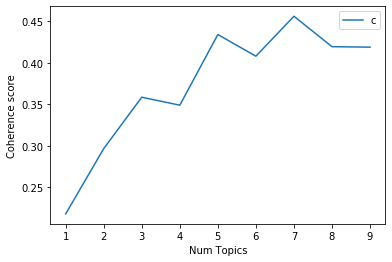

Num Topics = 1  is having Coherence Value of 0.218
Num Topics = 2  is having Coherence Value of 0.2966
Num Topics = 3  is having Coherence Value of 0.3586
Num Topics = 4  is having Coherence Value of 0.349
Num Topics = 5  is having Coherence Value of 0.4341
Num Topics = 6  is having Coherence Value of 0.408
Num Topics = 7  is having Coherence Value of 0.4561
Num Topics = 8  is having Coherence Value of 0.4195
Num Topics = 9  is having Coherence Value of 0.4189


In [173]:
# define a helper function
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# run and save
model_list, coherence_values = coherence_values_computation(
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=1, limit=10, step=1)

# Plot
import matplotlib.pyplot as plt
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

In [183]:
## Determine the Optimal Model
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"get" + 0.051*"win" + 0.045*"put" + 0.042*"caught_violate" + '
  '0.042*"two_reason" + 0.042*"re_chump" + 0.031*"covid" + 0.029*"think" + '
  '0.028*"patient" + 0.026*"hospital"'),
 (1,
  '0.072*"come_under" + 0.056*"apparently_breake" + 0.056*"lockdown_rule" + '
  '0.034*"region" + 0.029*"use" + 0.028*"lockdown" + 0.020*"rt" + 0.016*"mask" '
  '+ 0.013*"wear" + 0.010*"mark"'),
 (2,
  '0.094*"https" + 0.078*"co" + 0.038*"covid" + 0.030*"how" + 0.026*"pandemic" '
  '+ 0.026*"more" + 0.020*"rt" + 0.019*"mask_safely" + 0.019*"odggqxakp" + '
  '0.018*"government"'),
 (3,
  '0.043*"https" + 0.043*"co" + 0.036*"take" + 0.031*"vaccine" + 0.026*"say" + '
  '0.023*"rt" + 0.017*"leadership" + 0.016*"will" + 0.014*"people" + '
  '0.014*"covid"'),
 (4,
  '0.078*"coronavirus" + 0.049*"covid" + 0.041*"death" + 0.036*"country" + '
  '0.032*"case" + 0.031*"co" + 0.031*"https" + 0.029*"new" + 0.025*"day" + '
  '0.024*"report"'),
 (5,
  '0.051*"vaccine" + 0.050*"public" + 0.048*"rule" + 0.